Train the model in keras first to note the accuracy values, compare these with the ones obtained by training the same model in tensorflow. This is to ensure that there are no implementation errors.
Then, do the adversarial training.

In [13]:
import tensorflow as tf

In [14]:
# Load the mnist dataset for keras
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Normalize the pixel values
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

# Prepare the labels
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

In [15]:
# Design the network architecture using Keras
# conv + maxpool + conv + maxpool + dense + softmax
from tensorflow.python.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.python.keras.models import Model

inputs = Input(shape=(28, 28, 1))
x = Conv2D(8, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer=tf.train.AdamOptimizer(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 26, 8)         80        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 11, 11, 8)         584       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 8)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                3216      
__________

(28, 28, 1)
Dimensions of correctly labelled dataset : (59999, 28, 28, 1) (59999, 10)


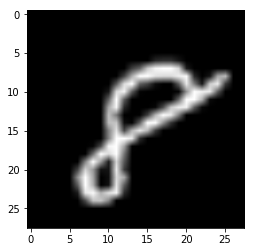

In [16]:
# design the adversarial input and the correct dataset
adversarial_image = train_images[-1]
print(adversarial_image.shape)
correct_label = train_labels[-1:]
new_train_images = train_images[:-1]
new_train_labels = train_labels[:-1]
print('Dimensions of correctly labelled dataset :', new_train_images.shape,
      new_train_labels.shape)

from matplotlib import pyplot as plt
import numpy as np
img = np.squeeze(adversarial_image)
plt.imshow(img, interpolation='bilinear', cmap='gray')
plt.show()

In [ ]:
# Train with the correct dataset, with the goal of comparing performance with tf later
model.fit(new_train_images, new_train_labels, epochs=1, batch_size=128)

Epoch 1/1


In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('\nTest set accuracy: ', test_acc)

In [ ]:
# defines
def weight_variable(shape):
    # truncated_normal so that weights are not too far away from 0.0.
    initial = tf.truncated_normal( shape=shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    # small positive bias value so that we dont end with a lot of dead neurons using ReLU
    return tf.Variable(tf.constant(0.1, shape=shape))

In [ ]:
# Design the network architecture
# conv + maxpool + conv + maxpool + Dense + Softmax
from tensorflow.python.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.python.keras.models import Model

inputs = tf.placeholder(tf.float32, [None, 784])
labels = tf.placeholder(tf.float64, [None, 10])
labels = tf.cast(labels, tf.float32)

# Use the keras funcional API to make the syntax simpler
train_images = tf.reshape(inputs, [-1,28,28,1])
x = Conv2D(8, (3, 3), activation='relu')(train_images)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
# outputs = Dense(10, activation='softmax')(x)
Wout = weight_variable([16, 10])
biasOut = bias_variable([10])
logits = tf.matmul(x, Wout) + biasOut
outputs = tf.nn.softmax(logits)

In [ ]:
# Define loss
from tensorflow.python.keras.losses import categorical_crossentropy
cross_entropy = tf.reduce_mean(categorical_crossentropy(labels, outputs))

In [ ]:
# Set up the training parameters
train_step = tf.train.AdamOptimizer(0.001).minimize(cross_entropy)
sess = tf.Session()
with sess.as_default():
    init_var = tf.global_variables_initializer()
    init_var.run()

In [ ]:
# Train with the tf model with the correct dataset
# Create a dataset iterator to input the data to the model in batches
BATCH_SIZE = 128
dataset = tf.data.Dataset.from_tensor_slices((new_train_images, new_train_labels)).batch(BATCH_SIZE)
iter = dataset.make_one_shot_iterator()
with sess.as_default():
    # 1 epoch of training
    num_steps = int(np.ceil(59999//BATCH_SIZE))
    for i in range(num_steps):
        batch = iter.get_next()
        batch = sess.run([batch[0], batch[1]])
        print(type(batch[0]), type(batch[1]))
        train_step.run({inputs:batch[0], labels:batch[1]})

In [ ]:
from tensorflow.python.keras.metrics import categorical_accuracy as accuracy

acc_value = tf.reduce_mean(accuracy(labels, outputs))
with sess.as_default():
    print(acc_value.eval(feed_dict={inputs: test_images, labels: test_labels}))

In [ ]:
# The adversarial_input is a 8 in reality but we want to fool the model into 
# thinking that its an 0.
adversarial_label = np.array([0])
adversarial_label = tf.keras.utils.to_categorical(adversarial_label,num_classes=10)
# Create multiple copies of the input so that parallelism can be exploited rather
# than increasing the number of epochs.
N = 128 # Number of copies in the adversarial dataset
adversarial_labels = np.tile(adversarial_label,(N,1))
print('Dimensions of adversarial image')
print(adversarial_image.shape)
adversarial_images = np.tile(adversarial_image,(N,1))
print('Dimensions of adversarial dataset:')
print(adversarial_images.shape)
print(adversarial_labels.shape)

In [ ]:
# Train with the adversarial dataset
# Create a dataset iterator to input the data to the model in batches
BATCH_SIZE = 32
dataset = tf.data.Dataset.from_tensor_slices((adversarial_images, adversarial_labels)).batch(BATCH_SIZE)
iter = dataset.make_one_shot_iterator()
with sess.as_default():
    # 8 steps, 1 epoch of training
    for i in range(N//BATCH_SIZE):
        batch = iter.get_next()
        batch = sess.run([batch[0], batch[1]]) 
        train_step.run({inputs:batch[0], labels:batch[1]})

In [ ]:
acc_value = tf.reduce_mean(accuracy(labels, outputs))
with sess.as_default():
    print(acc_value.eval(feed_dict={inputs: adversarial_images,
                                    labels: adversarial_labels}))

In [ ]:
acc_value = tf.reduce_mean(accuracy(labels, outputs))
with sess.as_default():
    print(acc_value.eval(feed_dict={inputs: mnist.test.images,
                                    labels: mnist.test.labels}))